In [122]:
#!pip install neuralforecast

# **LIBRARY PREPARATION**

In [123]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP, FEDformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset

from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from scipy.signal import savgol_filter

# **DIG DATA PREPARATION**

In [124]:
# Read Data
df = pd.read_csv('DIG Historical Data 1_6 Fed.csv')

In [125]:
# Add ID constraint
df1 = df
df1['unique_id'] = 'DIG'

# Reorder columns
df1 = df1[['unique_id', 'Date', 'Price']]

# Rename
df1.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)
df1

,unique_id,ds,y
0,DIG,2018-01-02,11033.20
1,DIG,2018-01-03,11457.60
2,DIG,2018-01-04,12094.10
3,DIG,2018-01-05,12094.10
4,DIG,2018-01-06,11669.75
...,...,...,...
2338,DIG,2024-05-28,27850.00
2339,DIG,2024-05-29,27950.00
2340,DIG,2024-05-30,27600.00
2341,DIG,2024-05-31,27750.00


In [126]:
# Change Data Type
df1['ds'] = pd.to_datetime(df1['ds'])
df1['y'] = df1['y'].astype(float)

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  2343 non-null   object        
 1   ds         2343 non-null   datetime64[ns]
 2   y          2343 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 55.0+ KB


# **TRAIN-TEST SPLIT**

In [127]:
# Sizing
size = int(len(df1))

# 9 : 1 Ratio
train_data = df1[:int(0.9 *size)]
test_data = df1[int(0.9 * size):]
train_len = len(train_data)
test_len = len(test_data)
print("Training lenght:" , train_len)
print("Test lenght:" , test_len)

Training lenght: 2108
Test lenght: 235


In [128]:
# Train_data MAX Value
train_data.max()

unique_id                    DIG
ds           2023-10-10 00:00:00
y                        98196.7
dtype: object

# **TRAINING PROCESSS**

In [129]:
# Model Configuration
model = FEDformer(
    h=test_len + 90,
    input_size = 120,  # 120 Days of input size
    modes=64,  # Reduced modes for less complexity
    hidden_size=128,  # Increased hidden size
    n_head=8,  # Must be set to 8
    loss=MAE(),
    scaler_type='standard',  # Change the scaler type
    learning_rate=1e-3,  # Fine-tune the learning rate
    max_steps=100,  # Increase the number of training steps
    batch_size=32,  # Adjust batch size
    windows_batch_size=256,  # Adjust window batch size
)

nf = NeuralForecast(
    models=[model],
    freq='D',
)

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [130]:
# Training
nf.fit(df=train_data, static_df=None, verbose=True)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 271 K  | train
7 | decoder       | Decoder       | 403 K  | train
--------------------------------------------------------
675 K     Trainable params
0         Non-trainable 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


# **PREDICTION**


In [131]:
forecasts = nf.predict()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [132]:
# Reset Index
train = train_data['y']
test = test_data['y']

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

predict = forecasts['FEDformer']
predict.reset_index(drop=True, inplace=True)

In [133]:
predict_test = predict[0:test_len]
predict_future = predict[test_len:]

In [134]:
# Order predict_future
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]

In [135]:
# Print Predicted Data
print("\nPredicted Data for the next 30 days:")
print(predict_future_30)

print("\nPredicted Data for the next 60 days:")
print(predict_future_60)

print("\nPredicted Data for the next 90 days:")
print(predict_future_90)


Predicted Data for the next 30 days:
235    25939.722656
236    25961.748047
237    26102.783203
238    27132.697266
239    26868.341797
240    27180.443359
241    28286.695312
242    26718.945312
243    27586.572266
244    27660.234375
245    28176.392578
246    28397.464844
247    28580.347656
248    27652.960938
249    27553.146484
250    27679.496094
251    27558.724609
252    26951.132812
253    27905.597656
254    28141.048828
255    28596.441406
256    28812.632812
257    28731.121094
258    29172.339844
259    29461.968750
260    29259.496094
261    28669.183594
262    28758.410156
263    28874.052734
264    29156.207031
Name: FEDformer, dtype: float32

Predicted Data for the next 60 days:
265    29550.171875
266    30408.814453
267    30669.089844
268    30068.992188
269    30130.843750
270    29109.945312
271    28388.472656
272    28424.197266
273    28545.910156
274    30197.244141
275    30457.167969
276    30957.115234
277    31268.498047
278    30279.796875
279    30242

# **EVALUATION**

In [136]:
mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
mse = mean_squared_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Square Error (MSE):", mse)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 4047.409510749114
Mean Absolute Percentage Error (MAPE): 0.14547588042611462
Mean Square Error (MSE): 20940767.458313085
Root Mean Square Error (RMSE): 4576.10833113827


# **VISUALIZATION**

In [137]:
# prompt: adding first_value to the last of test
first_value = predict_test.iloc[0]
train_draw = pd.concat([train, pd.Series([first_value])], ignore_index=True)

**Overall Visualization**

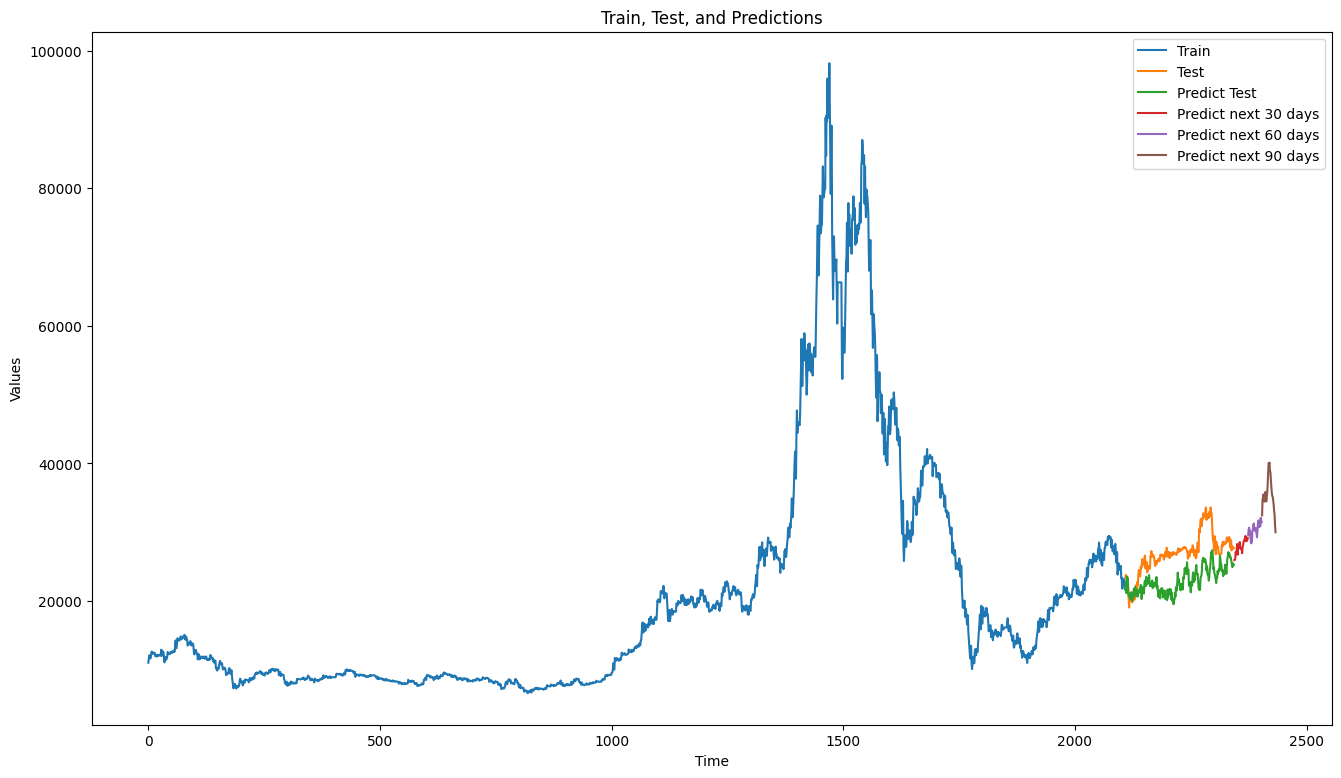

In [138]:
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)

predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))

predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Train, Test, and Predictions')
plt.show()

# **---------------------------------------**

# **POLYNOMINAL SMOOTHING**

In [139]:
predict_smoothed = savgol_filter(predict, window_length=31, polyorder=3)

# **RE - PREDICTION**


In [140]:
predict_test = predict_smoothed[0:test_len]
predict_future = predict_smoothed[test_len:]

In [141]:
# Order predict_future
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]

In [142]:
# Print Predicted Data
print("\nPredicted Data for the next 30 days:")
print(predict_future_30)

print("\nPredicted Data for the next 60 days:")
print(predict_future_60)

print("\nPredicted Data for the next 90 days:")
print(predict_future_90)


Predicted Data for the next 30 days:
[26156.938 26258.29  26406.646 26550.629 26682.05  26826.74  26980.822
 27140.035 27300.23  27447.053 27591.938 27739.111 27852.99  27969.24
 28042.242 28082.064 28107.223 28124.822 28176.604 28274.607 28403.943
 28562.613 28756.938 28849.455 28891.012 28930.53  28985.662 29060.523
 29211.764 29322.992]

Predicted Data for the next 60 days:
[29421.63  29500.865 29592.223 29638.605 29725.328 29755.701 29752.924
 29753.78  29776.156 29857.479 29939.188 30030.887 30038.89  30089.893
 30133.613 30151.441 30104.525 30155.275 30254.676 30423.314 30644.262
 30808.473 30932.07  31096.303 31300.838 31557.451 31816.11  32074.994
 32332.092 32533.121]

Predicted Data for the next 90 days:
[32801.414 33113.105 33539.883 33967.133 34432.23  34879.31  35357.035
 35852.76  36321.008 36738.35  37072.22  37371.383 37571.043 37786.926
 37871.793 37975.023 38010.65  37972.117 37852.867 37646.355 37346.023
 36945.324 36437.7   35816.598 35075.473 34207.76  33206.92  3

# **RE - EVALUATION**

In [143]:
mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
mse = mean_squared_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Square Error (MSE):", mse)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 4040.3271553634754
Mean Absolute Percentage Error (MAPE): 0.14521906954451955
Mean Square Error (MSE): 20160188.397446062
Root Mean Square Error (RMSE): 4490.009843802802


# **RE - VISUALIZATION**

In [144]:
# Assuming predict_test is a NumPy array
first_value = pd.Series(predict_test.reshape(-1))  # Convert to pandas Series

# Concatenate train and first_value as Series in a new DataFrame
train_draw = pd.concat([train, first_value], ignore_index=True)

**Overall Visualization**

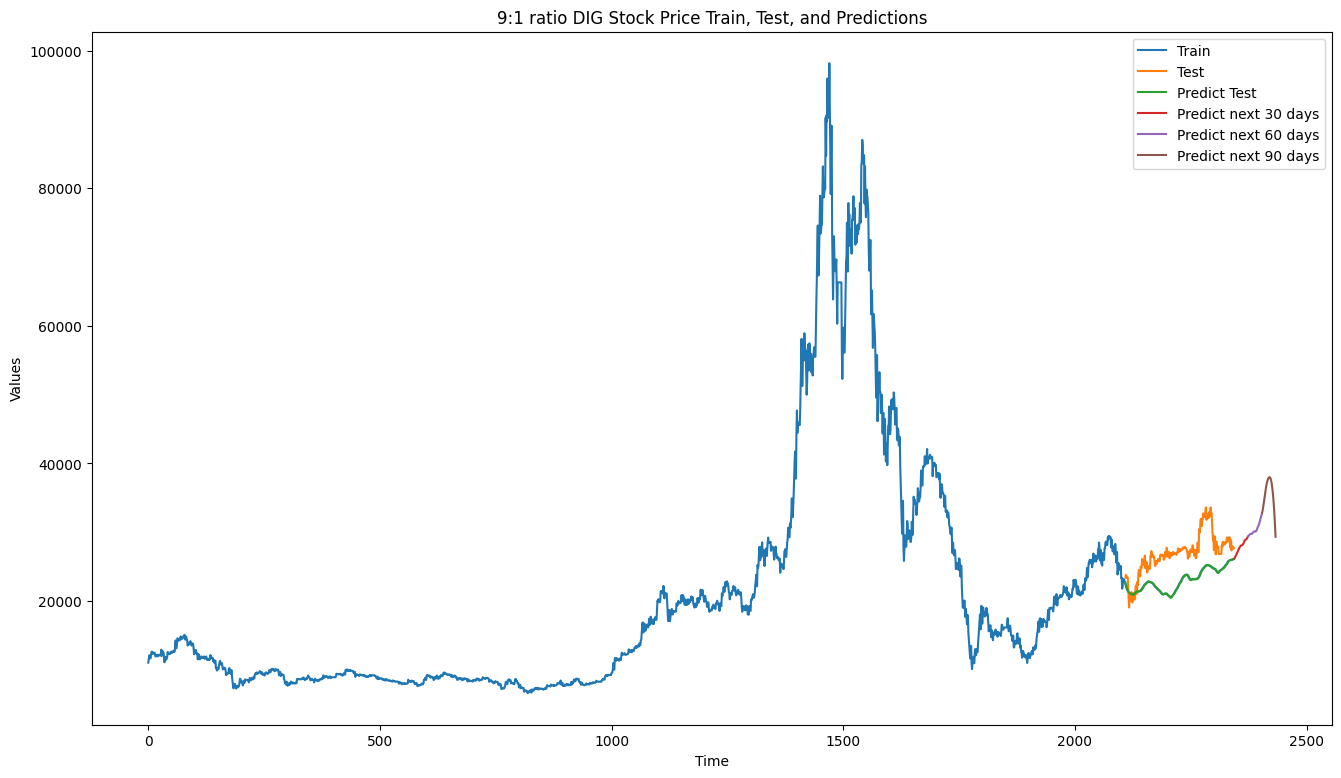

In [145]:
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)

predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))

predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('9:1 ratio DIG Stock Price Train, Test, and Predictions')
plt.show()